In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import cv2

from tensorflow.contrib.keras.python.keras.datasets import mnist
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers.recurrent import SimpleRNN, LSTM, GRU
from tensorflow.contrib.keras.python.keras.optimizers import RMSprop, Adadelta, Adam
from tensorflow.contrib.keras.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.contrib.keras.python.keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten
from tensorflow.contrib.keras.python.keras.layers.wrappers import TimeDistributed
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping
from tensorflow.contrib.keras.python.keras.regularizers import l1, l2
from tensorflow.contrib.keras.python.keras.utils.vis_utils import plot_model

from tensorflow.contrib.keras.python.keras.models import model_from_json

from tensorflow.contrib.keras.python.keras import backend as K

from natsort import natsorted
from IPython.display import clear_output

K.set_learning_phase(1)

# Training data

#### Count # of video in training data

In [2]:
# PATH = 'E:/EmotiW2017/lstm/Train_AFEW'
PATH = 'E:/EmotiW2017/lstm/original/Train_AFEW'

n_vids_train = 0

for emo in os.listdir(PATH):
    full_emo = PATH + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = full_emo + '/' + vid
            
            n_vids_train += 1

print(' > %d videos found' % (n_vids_train))

 > 726 videos found


#### Count # of frames in each video in training data

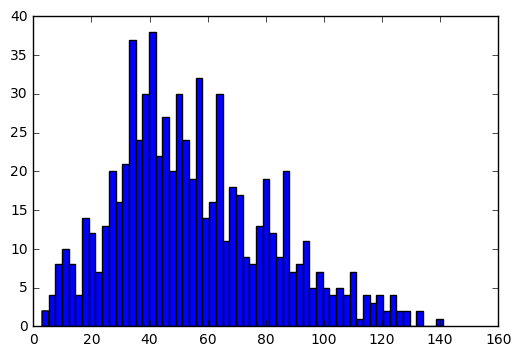

In [3]:
n_fra_stat_train = np.zeros((n_vids_train, 1))

vid_indx = 0

for emo in os.listdir(PATH):
    full_emo = PATH + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = full_emo + '/' + vid
            for fra in os.listdir(full_vid):
                full_fra = full_vid + '/' + fra
                if os.path.isfile(full_fra):
                    n_fra_stat_train[vid_indx, 0] += 1
                    
            vid_indx += 1

plt.hist(n_fra_stat_train, bins=60)
plt.show()

In [4]:
# n_fra_stat_train

In [5]:
print(np.average(n_fra_stat_train))
print(stats.mode(n_fra_stat_train))

55.1845730028
ModeResult(mode=array([[ 39.]]), count=array([[17]]))


# Validation data

In [6]:
# PATH = 'E:/EmotiW2017/lstm/Val_AFEW'
PATH = 'E:/EmotiW2017/lstm/original/Val_AFEW'

n_vids_test = 0

for emo in os.listdir(PATH):
    full_emo = PATH + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = full_emo + '/' + vid
            
            n_vids_test += 1

print(' > %d videos found' % (n_vids_test))

 > 383 videos found


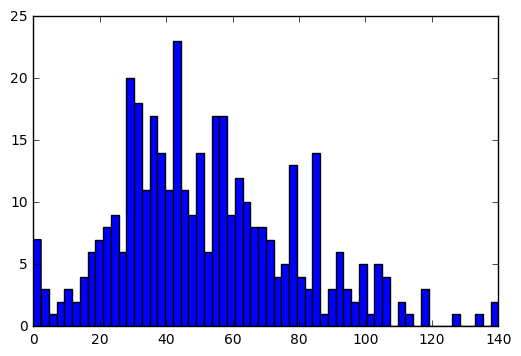

In [7]:
n_fra_stat_test = np.zeros((n_vids_test, 1))

vid_indx = 0

for emo in os.listdir(PATH):
    full_emo = PATH + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = full_emo + '/' + vid
            for fra in os.listdir(full_vid):
                full_fra = full_vid + '/' + fra
                if os.path.isfile(full_fra):
                    n_fra_stat_test[vid_indx, 0] += 1
                    
            vid_indx += 1

plt.hist(n_fra_stat_test, bins=60)
plt.show()

In [8]:
print(np.average(n_fra_stat_test))
print(stats.mode(n_fra_stat_test))

52.1592689295
ModeResult(mode=array([[ 54.]]), count=array([[11]]))


# Data processing

In [45]:
# We will process maxToAdd frames each video to recognize facial expression
maxToAdd = 16
size = 64

In [46]:
def emo2int(emo):
    if emo == 'Angry':
        return 0
    elif emo == 'Disgust':
        return 1
    elif emo == 'Fear':
        return 2
    elif emo == 'Happy':
        return 3
    elif emo == 'Neutral':
        return 4
    elif emo == 'Sad':
        return 5
    else:
        return 6

#### Training data

X_train shape:  (726, 16, 64, 64, 1)
y_train shape:  (726,)


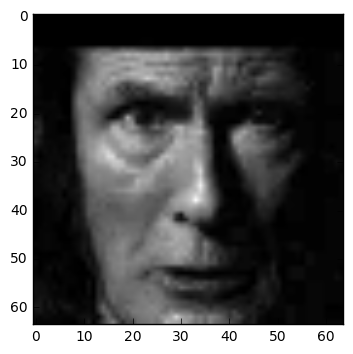

In [47]:
X_train = []
y_train = []

X_train = np.zeros((n_vids_train, maxToAdd, size, size, 1))

# PATH = 'E:/EmotiW2017/lstm/Train_AFEW'
PATH = 'E:/EmotiW2017/lstm/original/Train_AFEW'

vid_indx = 0

for emo in os.listdir(PATH):
    full_emo = PATH + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = full_emo + '/' + vid
            
            # Initialize a training example of max_num_time_steps, im_size, im_size
            output = np.zeros((maxToAdd, size, size, 1))
            
            # Decide how many images to put in that tensor
            numToAdd = int(np.min((maxToAdd, n_fra_stat_train[vid_indx, 0])))
            
            # Sample that images
            fra_indx = 0
            example = np.zeros((numToAdd, size, size))
            for fra in os.listdir(full_vid):
                if fra_indx < numToAdd:
                    full_fra = full_vid + '/' + fra
                    if os.path.isfile(full_fra):
                        img = cv2.imread(full_fra)
                        img = cv2.resize(img, (size, size))
                        img = img[:, :, 0]
                        example[fra_indx] = img
                        
                        fra_indx += 1
                else:
                    break
            
            output[0:numToAdd, :, :, 0] = example
            X_train[vid_indx, :, :, :, :] = output
            
            # Get the label for current video
            y_train.append(emo2int(emo))
            
            vid_indx += 1

y_train = np.array(y_train)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

plt.imshow(X_train[0, 0, :, :, 0], cmap='gray')
plt.show()

In [48]:
# X_train = np.load('afew2017_training_aligned_resampling_x.npy')
# y_train = np.load('afew2017_training_aligned_resampling_y.npy')

# print("X_train shape: ", X_train.shape)
# print("y_train shape: ", y_train.shape)

# plt.imshow(X_train[0, 0, :, :, 0], cmap='gray')
# plt.show()

In [49]:
# for i in range(0, 2):
#     for j in range(maxToAdd):
#         clear_output(wait=True)
#         plt.imshow(X_train[i, j, :, :, 0], cmap='gray')
#         plt.suptitle('video ' + str(i) + ' @ frame ' + str(j))
#         plt.show()
#         y_train[i]

#### Validation data

X_test shape:  (383, 16, 64, 64, 1)
y_test shape:  (383,)


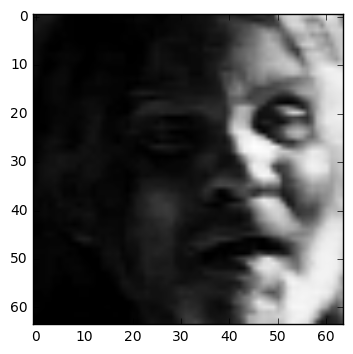

In [50]:
X_test = []
y_test = []

X_test = np.zeros((n_vids_test, maxToAdd, size, size, 1))

# PATH = 'E:/EmotiW2017/lstm/Val_AFEW'
PATH = 'E:/EmotiW2017/lstm/original/Val_AFEW'

vid_indx = 0

for emo in natsorted(os.listdir(PATH)):
    full_emo = PATH + '/' + emo
    if os.path.isdir(full_emo):
        for vid in natsorted(os.listdir(full_emo)):
            full_vid = full_emo + '/' + vid
            
            # Initialize a testing example of max_num_time_steps, im_size, im_size
            output = np.zeros((maxToAdd, size, size, 1))
            
            # Decide how many images to put in that tensor
            numToAdd = int(np.min((maxToAdd, n_fra_stat_test[vid_indx, 0])))
            
            # Sample that images
            fra_indx = 0
            example = np.zeros((numToAdd, size, size))
            for fra in natsorted(os.listdir(full_vid)):
                if fra_indx < numToAdd:
                    full_fra = full_vid + '/' + fra
                    if os.path.isfile(full_fra):
                        img = cv2.imread(full_fra)
                        img = cv2.resize(img, (size, size))
                        img = img[:, :, 0]
                        example[fra_indx] = img
                        
                        fra_indx += 1
                else:
                    break
            
            output[0:numToAdd, :, :, 0] = example
            X_test[vid_indx, :, :, :, :] = output
            
            # Get the label for current video
            y_test.append(emo2int(emo))
                
            vid_indx += 1

y_test = np.array(y_test)

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

plt.imshow(X_test[0, 0, :, :, 0], cmap='gray')
plt.show()

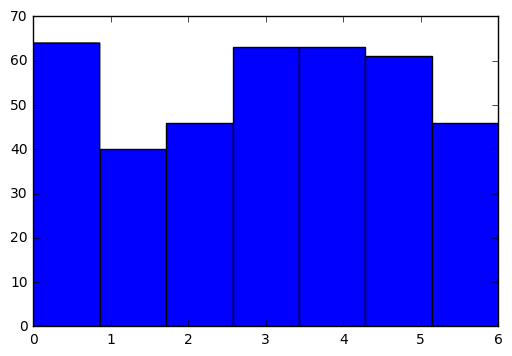

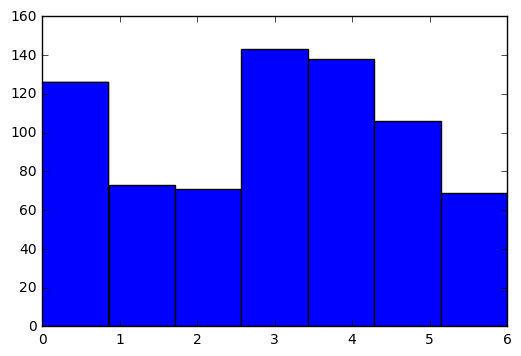

In [51]:
plt.hist(y_test, bins=7)
plt.show()

plt.hist(y_train, bins=7)
plt.show()

# CNN-LSTM

In [52]:
# Define CNN-LSTM
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='valid'), input_shape=(maxToAdd, size, size, 1)))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))

model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))

model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))

model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))

model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Flatten()))

model.add(Activation('relu'))

model.add(LSTM(units=1024, return_sequences=False, recurrent_dropout=0.25, kernel_regularizer=l2(0.001)))
# model.add(LSTM(units=512, return_sequences=True))
# model.add(LSTM(units=512, return_sequences=False))

# model.add(Dense(7, activation='softmax', kernel_regularizer=l2(0.001)))
model.add(Dense(7, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_154 (TimeDi (None, 16, 62, 62, 32)    320       
_________________________________________________________________
time_distributed_155 (TimeDi (None, 16, 60, 60, 32)    9248      
_________________________________________________________________
time_distributed_156 (TimeDi (None, 16, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_157 (TimeDi (None, 16, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_158 (TimeDi (None, 16, 30, 30, 32)    9248      
_________________________________________________________________
time_distributed_159 (TimeDi (None, 16, 28, 28, 32)    9248      
_________________________________________________________________
time_distributed_160 (TimeDi (None, 16, 14, 14, 32)    0         
__________

In [53]:
opt = Adam(lr=0.0001)
# opt = RMSprop(lr=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [56]:
# batch_size = 197
batch_size = 64
n_epochs = 200

early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=1)

train_history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          shuffle=True, batch_size=batch_size, epochs=n_epochs, verbose=1,
          callbacks=[early_stopping])

Train on 726 samples, validate on 383 samples
Epoch 1/200
726/726 [==============================] - 5s - loss: 2.3994 - acc: 0.2273 - val_loss: 2.4481 - val_acc: 0.1880
Epoch 2/200
726/726 [==============================] - 4s - loss: 2.3818 - acc: 0.2135 - val_loss: 2.4248 - val_acc: 0.2141
Epoch 3/200
726/726 [==============================] - 4s - loss: 2.3534 - acc: 0.2094 - val_loss: 2.4221 - val_acc: 0.2037
Epoch 4/200
726/726 [==============================] - 4s - loss: 2.3343 - acc: 0.2342 - val_loss: 2.3902 - val_acc: 0.1854
Epoch 5/200
726/726 [==============================] - 4s - loss: 2.3247 - acc: 0.2287 - val_loss: 2.3851 - val_acc: 0.1619
Epoch 6/200
726/726 [==============================] - 4s - loss: 2.2955 - acc: 0.2493 - val_loss: 2.3704 - val_acc: 0.2115
Epoch 7/200
726/726 [==============================] - 4s - loss: 2.3042 - acc: 0.2149 - val_loss: 2.3734 - val_acc: 0.2089
Epoch 8/200
726/726 [==============================] - 4s - loss: 2.2875 - acc: 0.2424

In [57]:
plot_model(model, to_file='model.png', show_shapes=True)

In [58]:
score = model.evaluate(X_train, y_train)
print('Train score:', score[0])
print('Train accuracy:', score[1])

score = model.evaluate(X_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

726/726 [==============================] - 1s     
Train score: 0.478783888594
Train accuracy: 0.969696971339
383/383 [==============================] - 1s     
Test score: 3.47349877644
Test accuracy: 0.242819843109


dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


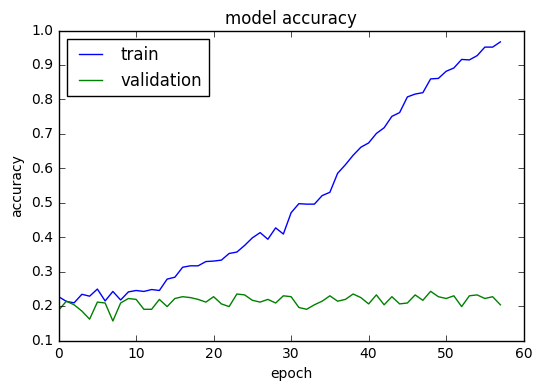

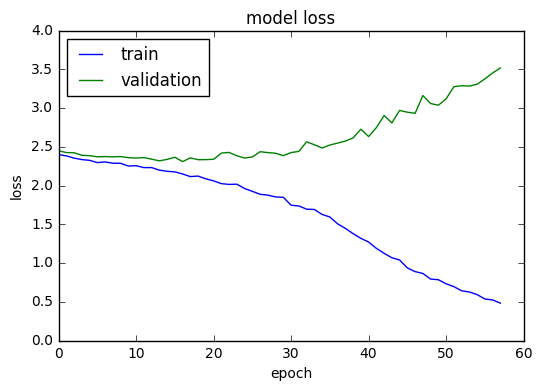

In [59]:
history_ = train_history.history

# list all data in history
print(history_.keys())
# summarize history for accuracy
plt.plot(history_['acc'])
plt.plot(history_['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()